# Chapter 6 - Exercises

> Author : Badr TAJINI - Large Language model (LLMs) - ESIEE 2024-2025

---


## Exercise 6.1: Increasing the context length

**Padding Input Sequences in Neural Language Models**

**Key Research Question: How does padding inputs to the maximum `token` length affect model predictive performance?**

*Methodological Approach:*
- Implement systematic `token` padding 
- Analyze padding's impact on model performance
- Explore input representation interactions

*Critical Parameters:*
- Input `padding` strategy
- Maximum `token` length
- Predictive performance metrics

*Recommended Investigation:*
1. Implement maximum-length input `padding`
2. Measure performance variations
3. Compare padded versus non-padded inputs
4. Assess computational implications

In [56]:
import tiktoken
import torch
import pandas as pd
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt

In [57]:
CHOOSE_MODEL = "gpt2-small (124M)"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = tiktoken.get_encoding("gpt2")

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [58]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

models\124M\checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 5.54kiB/s]
models\124M\encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 787kiB/s] 
models\124M\hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 22.4kiB/s]
models\124M\model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [13:25<00:00, 618kiB/s]   
models\124M\model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 642kiB/s]
models\124M\model.ckpt.meta: 100%|██████████| 471k/471k [00:02<00:00, 213kiB/s]  
models\124M\vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 458kiB/s] 


In [38]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [39]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### Padded inputs

In [40]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [41]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=120,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=120,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=120,
    tokenizer=tokenizer
)

In [42]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [43]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [44]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [45]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.00%
Validation accuracy: 98.75%
Test accuracy: 95.00%


In [46]:
train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.072
Validation loss: 0.081
Test loss: 0.354


### Non-padded

In [47]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=None,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [48]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader2 = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader2 = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader2 = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [49]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.00%
Validation accuracy: 98.75%
Test accuracy: 95.00%


In [50]:
train_loss = calc_loss_loader(train_loader2, model, device, num_batches=5)
val_loss = calc_loss_loader(val_loader2, model, device, num_batches=5)
test_loss = calc_loss_loader(test_loader2, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.072
Validation loss: 0.146
Test loss: 0.491


Les données non paddées ont une plus grande erreur que les données paddés

## Exercise 6.2: Finetuning the whole model

**Model-Wide Fine-Tuning Performance Assessment**

**Key Research Question: What is the impact of `fine-tuning` the entire transformer model versus a single final block on predictive performance?**


*Methodological Approach:*
- Implement comprehensive model `fine-tuning`
- Compare performance against single block tuning
- Assess computational and representational changes

*Critical Parameters:*
- Full model `fine-tuning` strategy
- Performance evaluation metrics
- Comparative analysis methodology

*Recommended Investigation:*
1. `Fine-tune` entire transformer model
2. Measure predictive performance metrics
3. Compare with previous single-block tuning results
4. Analyze performance variation mechanisms

In [59]:
model2 = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model2, params)
model2.eval();

In [60]:
torch.manual_seed(123)

num_classes = 2
model2.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [61]:
for param in model2.parameters():
    param.requires_grad = True

In [62]:
# Same as lab 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Overall the same as `train_model_simple` in lab 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [63]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model2.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model2, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.884, Val loss 2.596
Ep 1 (Step 000050): Train loss 0.293, Val loss 0.190
Ep 1 (Step 000100): Train loss 0.148, Val loss 0.501
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.162, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.004, Val loss 0.029
Ep 2 (Step 000250): Train loss 0.027, Val loss 0.100
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.009, Val loss 0.126
Ep 3 (Step 000350): Train loss 0.001, Val loss 0.009
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.004, Val loss 0.007
Ep 4 (Step 000450): Train loss 0.002, Val loss 0.004
Ep 4 (Step 000500): Train loss 0.004, Val loss 0.015
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.229, Val loss 0.066
Ep 5 (Step 000600): Train loss 0.007, Val loss 0.058
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in 78.98

In [64]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

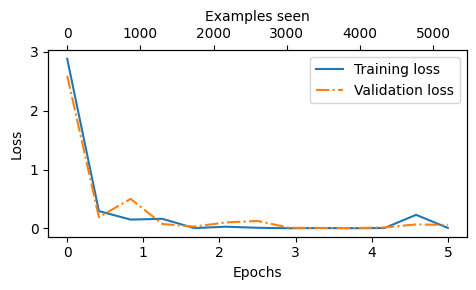

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

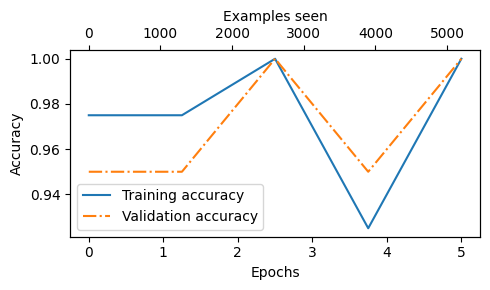

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [67]:
train_accuracy = calc_accuracy_loader(train_loader, model2, device)
val_accuracy = calc_accuracy_loader(val_loader, model2, device)
test_accuracy = calc_accuracy_loader(test_loader, model2, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.94%
Validation accuracy: 99.33%
Test accuracy: 97.00%


In [68]:
train_loss = calc_loss_loader(train_loader, model2, device, num_batches=5)
val_loss = calc_loss_loader(val_loader, model2, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model2, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.013
Validation loss: 0.028
Test loss: 0.410


Comparé au fine-tuning d'un seul block, le fine-tuning du model enntier prend beacoup plus de temps. Il y a aussi beaucoup plus d'overfitting. Dès l'epoch 3, on est a 100% de précision sur lesdonnées d'entrainement et de validation avec une erreur de 0.001 et 0.009.Comparé à cela, le fine-tuning d'un seul block à au même moment une précision 90% sur les données d'entrainement et de validation et une erreur de 0.340 et 0.306. De plus, la précision n'augmente pas de manière homogène. Elle baisse à la quatrième epoch passant de 100% à 95%. Au final, on obtient une meilleur précision sur les données de tests (97% contre 95.5%) et on a une perte très faible (0.41).


## Exercise 6.3: Finetuning the first versus last token 

**First Token Fine-Tuning: Predictive Performance Analysis**

**Key Research Question: How do predictive performance characteristics change when fine-tuning the first output `token` compared to the last output `token`?**

*Methodological Approach:*
- Fine-tune first output `token`
- Compare performance against last `token` fine-tuning
- Assess representational learning variations

*Critical Parameters:*
- Initial `token` fine-tuning strategy
- Performance evaluation metrics
- Comparative analysis methodology

*Recommended Investigation:*
1. Implement first `token` fine-tuning
2. Measure predictive performance
3. Compare with last `token` fine-tuning results
4. Analyze performance variation mechanisms

In [69]:
model3 = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model3, params)
model3.eval();

In [70]:
for param in model3.parameters():
    param.requires_grad = False

torch.manual_seed(123)

num_classes = 2
model3.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)


for param in model3.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model3.final_norm.parameters():
    param.requires_grad = True

In [71]:
def calc_accuracy_loader_first_token(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, 0, :]  # Logits of first output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples



def calc_loss_batch_first_token(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, 0, :]  # Logits of first output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader_first_token(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [72]:
def evaluate_model_first_token(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Overall the same as `train_model_simple` in lab 5
def train_classifier_simple_first_token(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch_first_token(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model_first_token(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader_first_token(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader_first_token(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [73]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer3 = torch.optim.AdamW(model3.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple_first_token(
    model3, train_loader, val_loader, optimizer3, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.283, Val loss 2.536
Ep 1 (Step 000050): Train loss 2.113, Val loss 2.118
Ep 1 (Step 000100): Train loss 1.637, Val loss 2.179
Training accuracy: 60.00% | Validation accuracy: 50.00%
Ep 2 (Step 000150): Train loss 2.120, Val loss 2.130
Ep 2 (Step 000200): Train loss 2.556, Val loss 2.225
Ep 2 (Step 000250): Train loss 1.866, Val loss 2.330
Training accuracy: 70.00% | Validation accuracy: 60.00%
Ep 3 (Step 000300): Train loss 1.743, Val loss 2.332
Ep 3 (Step 000350): Train loss 2.463, Val loss 2.475
Training accuracy: 72.50% | Validation accuracy: 57.50%
Ep 4 (Step 000400): Train loss 1.343, Val loss 2.436
Ep 4 (Step 000450): Train loss 2.592, Val loss 2.382
Ep 4 (Step 000500): Train loss 2.264, Val loss 2.368
Training accuracy: 75.00% | Validation accuracy: 60.00%
Ep 5 (Step 000550): Train loss 2.365, Val loss 2.493
Ep 5 (Step 000600): Train loss 2.145, Val loss 2.534
Training accuracy: 80.00% | Validation accuracy: 65.00%
Training completed in 40.03 min

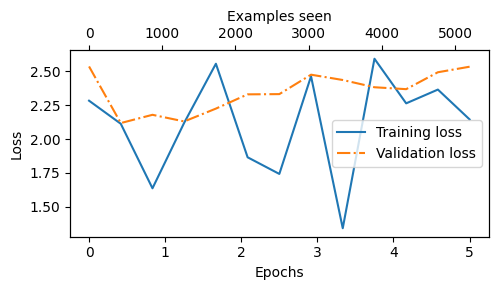

In [74]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

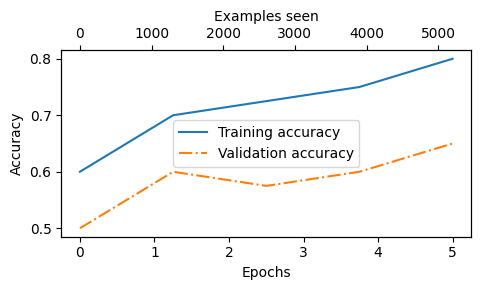

In [75]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [76]:
train_accuracy = calc_accuracy_loader(train_loader, model3, device)
val_accuracy = calc_accuracy_loader(val_loader, model3, device)
test_accuracy = calc_accuracy_loader(test_loader, model3, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 49.62%
Validation accuracy: 53.02%
Test accuracy: 50.33%


In [77]:
train_loss = calc_loss_loader(train_loader, model3, device, num_batches=5)
val_loss = calc_loss_loader(val_loader, model3, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model3, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.636
Validation loss: 2.507
Test loss: 2.258


Au cours du fine-tuning du premier token, les résultats sont inférieurs au résultats du fine-tuning du dernier token. La précision passe de 97.5% pour le fine-tuning du dernier token sur les données d'entrainement à 65% à l'epoch 5. Lerreur est aussi beaucoup plus élevé. On passe de 0.074 à 2.5 lors de l'epoch 5. Il y a aussi de l'overfitting comme on peut voir sur la courbe de la précision avec la précision des données de validation bien inférieur à la précision des données d'entrainement. C'est confirmé pars les résultats sur les données de tests. La précision passe de 95.5% pour le fine-tuning du dernier token à 50% pour le fine-tuning du premier token. Il y a aussi une perte très élevé: 2.258.